In [165]:
%matplotlib inline

In [166]:
import os
os.chdir("/home/jptalusan/mta_stationing_problem")
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_squared_error
from ast import literal_eval

# Plotting Same Day stop level evaluation

In [167]:
## Separate mean and max from baseline
fp = os.path.join('models', 'same_day', 'evaluation', 'baseline_multi_stop_10P_xF_results_max_mean.pkl')
df = pd.read_pickle(fp)
df = df.bfill()

df_max = df[['trip_id', 'y_true', 'y_pred_max']]
df_max = df_max.rename({'y_pred_max':'y_pred'}, axis=1)
fp = os.path.join('models', 'same_day', 'evaluation', 'baseline_multi_stop_10P_xF_results_max.pkl')
df_max.to_pickle(fp)

df_mean = df[['trip_id', 'y_true', 'y_pred_ave']]
df_mean = df_mean.rename({'y_pred_ave':'y_pred'}, axis=1)
fp = os.path.join('models', 'same_day', 'evaluation', 'baseline_multi_stop_10P_xF_results_mean.pkl')
df_mean.to_pickle(fp)

In [ ]:


def get_mse(x, length=None):
    if not length:
        y_true = [int(float(y)) for y in x.y_true]
        y_pred = [int(float(y)) for y in x.y_pred]
    else:
        if len(x.y_true) < length:
            length = len(x.y_true)
        y_true = [int(float(y)) for y in x.y_true[0:length]]
        y_pred = [int(float(y)) for y in x.y_pred[0:length]]
        
    return mean_squared_error(y_true, y_pred)
        
res_df_arr = []
multi_stop_results = ['SIMPLE_LSTM_multi_stop_5P_xF_results.pkl', 'baseline_multi_stop_10P_xF_results_max.pkl', 'baseline_multi_stop_10P_xF_results_mean.pkl']
for ms_result in multi_stop_results:
    fp = os.path.join('models/same_day/evaluation/', ms_result)
    res_df = pd.read_pickle(fp)[:200].bfill()
    res_df = res_df.groupby('trip_id').agg(list)
    res_df['mse'] = res_df.apply(lambda x: get_mse(x), axis=1)
    res_df['mse_1'] = res_df.apply(lambda x: get_mse(x, 1), axis=1)
    res_df['mse_5'] = res_df.apply(lambda x: get_mse(x, 5), axis=1)
    res_df['mse_10'] = res_df.apply(lambda x: get_mse(x, 10), axis=1)
    res_df_arr.append(res_df)

['', 'mse_1', '', 'mse_5', '', 'mse_10', '', 'mse', '']


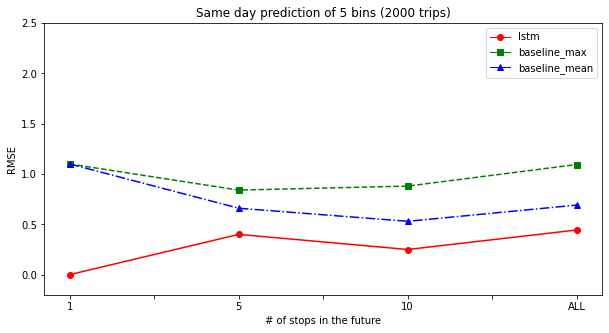

In [170]:
import matplotlib.pyplot as plt
# Plot ave MSE
fig, ax = plt.subplots(figsize=(10, 5))

marker = ['o', 's', '^', 'x']
color = ['r', 'g', 'b', 'k']
linestyle = ['-', '--', '-.', ':']
for i, line in enumerate(res_df_arr):
    
    res_df_arr[i][['mse_1', 'mse_5', 'mse_10', 'mse']].mean().plot(ax=ax, marker=marker[i], color=color[i], linestyle=linestyle[i])
    # line.set_marker(marker[i])
    # line.set_color(color[i])
#     # line.set_linestyle(linestyle[i])
labels = [item.get_text() for item in ax.get_xticklabels()]
print(labels)
labels[1] = 1
labels[3] = 5
labels[5] = 10
labels[7] = 'ALL'

ax.set_xticklabels(labels)

ax.set_ylabel('RMSE')
ax.set_xlabel('# of stops in the future')
from matplotlib.lines import Line2D
custom_lines = [
                Line2D([0], [0], color='red', lw=1, marker='o'),
                Line2D([0], [0], color='green', lw=1, marker='s'),
                Line2D([0], [0], color='blue', lw=1, marker='^'),
                Line2D([0], [0], color='k', lw=1, marker='x'),
               ]
ax.set_ylim(-0.2, 2.5)
ax.legend(custom_lines, ['lstm', 'baseline_max', 'baseline_mean'])
ax.set_title("Same day prediction of 5 bins (2000 trips)")
fp = os.path.join('plots', 'stop_level_prediction.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

# Comparing Day Ahead and Any Day with baselines

In [77]:
# Define evaluator, requires some time information (merge testX, testY and pred)
def generate_results_over_time_window(results_df_arr):
    mse_df = pd.DataFrame()
    for i, results_df in enumerate(results_df_arr):
        tdf = results_df[['time_window', 'y_pred', 'y_true']].groupby('time_window').agg({'y_pred': list, 'y_true': list})
        tdf['mse'] = tdf.apply(lambda x: mean_squared_error(x.y_true, x.y_pred, squared=False), axis=1)
        mse_df[i] = tdf['mse']
    return mse_df

In [31]:
import os
# os.chdir("/media/seconddrive/mta_stationing_problem")
import sys
sys.path.insert(0,'..')

print(os.getcwd())
from src.config import *
from pandas.core.common import SettingWithCopyWarning
from src import data_utils, triplevel_utils
from src import day_ahead_prediction_utils, any_day_prediction_utils
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.set_option('display.max_columns', None)
import xgboost as xgb
import importlib
importlib.reload(data_utils)

from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

/media/seconddrive/mta_stationing_problem


## Day Ahead

In [161]:
processed_triplevel = os.path.join('data', 'processed', 'triplevel_df.parquet')
df = pd.read_parquet(processed_triplevel, engine='auto')
df = df.dropna()
# Removing time_window in case a different one will be used
df = df.drop(['time_window', 'load'], axis=1)
df = df.reset_index(drop=True)
df = df.sort_values(['block_abbr', 'transit_date', 'arrival_time', 'route_id_direction'])

FOLDS = 3
RANDOM_SEED = 100
WINDOW = 30
PAST_TRIPS = 5
TARGET = 'y_reg100'

cat_features = ['route_id_direction', 'is_holiday', 'dayofweek']
ord_features = ['year', 'month', 'hour', 'day']
num_features = ['temperature', 'humidity', 'precipitation_intensity', 'avg_sched_headway', 'time_window', 'traffic_speed',
                'load_pct_change', 'act_headway_pct_change', 'avg_past_act_headway', 'avg_past_trips_loads']

tdf = triplevel_utils.generate_new_day_ahead_features(df, time_window=WINDOW, past_trips=PAST_TRIPS, target=TARGET)
tdf = tdf.groupby(['transit_date', 'route_id_direction', 'time_window']).agg({"year":"first", 
                                                                              "month":"first",
                                                                              "day": "first",
                                                                              "hour":"first",
                                                                              "is_holiday": "first",
                                                                              "dayofweek":"first",
                                                                              "temperature":"mean", 
                                                                              "humidity":"mean",
                                                                              "precipitation_intensity": "mean",
                                                                              "traffic_speed":"mean",
                                                                              "scheduled_headway": "max",
                                                                              "load_pct_change": "max",
                                                                              "act_headway_pct_change": "max",
                                                                              "avg_past_act_headway": "max",
                                                                              "avg_past_trips_loads": "max",
                                                                              TARGET: "max" })
tdf = tdf.reset_index(level=[0,1,2])
print("ohe_encoder is for the following column order:", cat_features)
rf_df, ix_map, ohe_encoder, percentiles = triplevel_utils.prepare_df_for_training(tdf, cat_features, ord_features, target=TARGET)
target_load = rf_df[[TARGET]]
drop_cols = ['route_id', 'route_direction_name', 'block_abbr', 'y_reg100', 'y_reg095', 'transit_date', 'is_holiday', 'route_id_direction', 'actual_headways', 'trip_id', 'arrival_time']
drop_cols = [col for col in drop_cols if col in rf_df.columns]
rf_df = rf_df.drop(drop_cols, axis=1)

y = rf_df.pop('y_class')
X = rf_df

ohe_encoder is for the following column order: ['route_id_direction', 'is_holiday', 'dayofweek']


In [162]:
# # Grid search results
fp = os.path.join('models', 'day_ahead', 'XGBOOST_RANDSEARCHCV_Day_Ahead_012.pkl')
search_results = joblib.load(fp)
print(search_results.best_params_)

{'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.05, 'gamma': 0.1}


In [163]:
columns = rf_df.columns

n_estimators  = search_results.best_params_['n_estimators']
max_depth     = search_results.best_params_['max_depth']
learning_rate = search_results.best_params_['learning_rate']
gamma         = search_results.best_params_['gamma']
objective = 'multi:softmax'

skf = StratifiedKFold(n_splits=FOLDS, random_state=RANDOM_SEED, shuffle=True)
skf.get_n_splits(X, y)

results_df_arr = []
for train_index, test_index in skf.split(X, y):
    _X_train, _X_test = X.iloc[train_index], X.iloc[test_index]
    _y_train, _y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth,
                              learning_rate=learning_rate, use_label_encoder=False, 
                              gamma=gamma, num_class=3,
                              objective=objective, eval_metric='mlogloss')
    # model = xgb.XGBClassifier(use_label_encoder=False, objective=objective, eval_metric='mlogloss', num_class=3)
    model.fit(_X_train, _y_train, verbose=1)

    preds = model.predict(_X_test)
    _X_test = pd.DataFrame(_X_test, columns=columns)
    _X_test['y_pred'] = preds
    _X_test['y_true'] = _y_test
    res_df = _X_test[['time_window', 'y_true', 'y_pred']]
    results_df_arr.append(res_df)

mse_df = generate_results_over_time_window(results_df_arr)
fp = os.path.join('evaluation', 'day_ahead_012_results.pkl')
mse_df.to_pickle(fp)

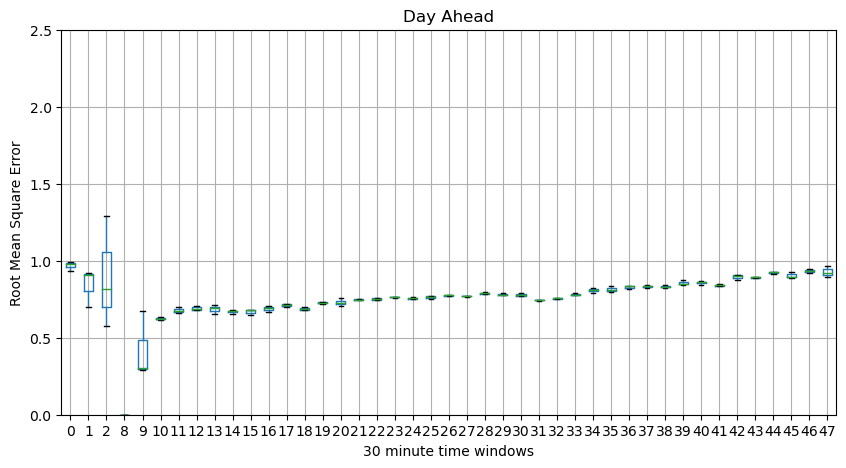

In [164]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

fig, ax = plt.subplots(figsize=(10, 5))
mse_df['time_window'] = mse_df.index
mse_df['time_window'].to_numpy()
mse_df['time_window'] = mse_df['time_window'].to_numpy().astype('int')
mse_df = mse_df.reset_index(drop=True).set_index('time_window')

mse_df.T.boxplot(ax=ax)

ax.set_title("Day Ahead")
ax.set_ylabel("Root Mean Square Error")
ax.set_xlabel("30 minute time windows")
ax.set_ylim(0.0, 2.5)

fp = os.path.join('plots', 'day_ahead_012.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

In [99]:
rf_df, ix_map, ohe_encoder, percentiles = triplevel_utils.prepare_df_for_training(tdf, cat_features, ord_features, target=TARGET)
rf_df, percentiles = triplevel_utils.adjust_bins(rf_df, TARGET=TARGET, percentiles=percentiles)
drop_cols = ['route_id', 'route_direction_name', 'block_abbr', 'y_reg100', 'y_reg095', 'transit_date', 'is_holiday', 'route_id_direction']
drop_cols = [col for col in drop_cols if col in rf_df.columns]
rf_df = rf_df.drop(drop_cols, axis=1)
rf_df = rf_df[rf_df['y_class'] >= 2]

y = rf_df.pop('y_class')
y = y - 2
X = rf_df

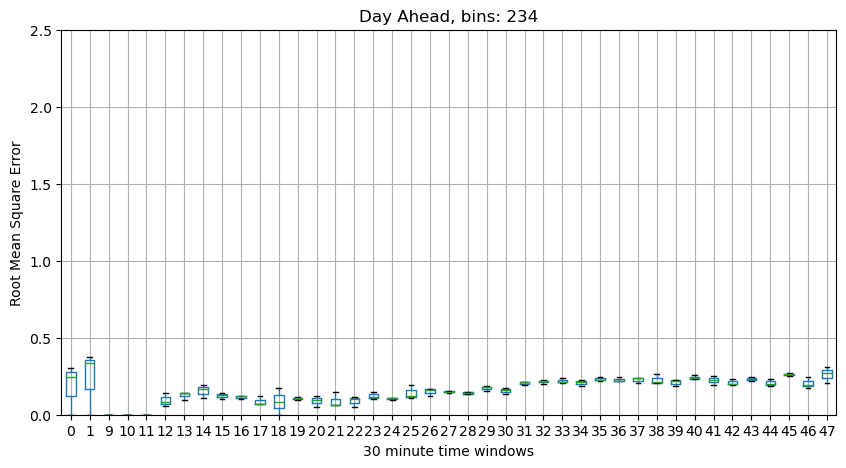

In [100]:
columns = rf_df.columns

# n_estimators  = search_results.best_params_['n_estimators']
# max_depth     = search_results.best_params_['max_depth']
# learning_rate = search_results.best_params_['learning_rate']
# gamma         = search_results.best_params_['gamma']
objective = 'multi:softmax'

skf = StratifiedKFold(n_splits=FOLDS, random_state=RANDOM_SEED, shuffle=True)
skf.get_n_splits(X, y)

results_df_arr = []
for train_index, test_index in skf.split(X, y):
    _X_train, _X_test = X.iloc[train_index], X.iloc[test_index]
    _y_train, _y_test = y.iloc[train_index], y.iloc[test_index]
    
    # model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth,
    #                           learning_rate=learning_rate, use_label_encoder=False, 
    #                           gamma=gamma, num_class=3,
    #                           objective=objective, eval_metric='mlogloss')
    model = xgb.XGBClassifier(use_label_encoder=False, objective=objective, eval_metric='mlogloss', num_class=3)
    model.fit(_X_train, _y_train, verbose=1)

    preds = model.predict(_X_test)
    _X_test = pd.DataFrame(_X_test, columns=columns)
    _X_test['y_pred'] = preds
    _X_test['y_true'] = _y_test
    res_df = _X_test[['time_window', 'y_true', 'y_pred']]
    results_df_arr.append(res_df)

mse_df = generate_results_over_time_window(results_df_arr)
fp = os.path.join('evaluation', 'day_ahead_234_results.pkl')
mse_df.to_pickle(fp)

fig, ax = plt.subplots(figsize=(10, 5))
mse_df['time_window'] = mse_df.index
mse_df['time_window'].to_numpy()
mse_df['time_window'] = mse_df['time_window'].to_numpy().astype('int')
mse_df = mse_df.reset_index(drop=True).set_index('time_window')

mse_df.T.boxplot(ax=ax)

ax.set_title("Day Ahead, bins: 234")
ax.set_ylabel("Root Mean Square Error")
ax.set_xlabel("30 minute time windows")
ax.set_ylim(0.0, 2.5)

fp = os.path.join('plots', 'day_ahead_simple_234.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

## Any Ahead

In [101]:
processed_triplevel = os.path.join('data', 'processed', 'triplevel_df.parquet')
df = pd.read_parquet(processed_triplevel, engine='auto')
df = df.dropna()
# Removing time_window in case a different one will be used
df = df.drop(['time_window', 'load'], axis=1)
df = df.reset_index(drop=True)
df = df.sort_values(['block_abbr', 'transit_date', 'arrival_time', 'route_id_direction'])

FOLDS = 3
RANDOM_SEED = 100
WINDOW = 30
PAST_TRIPS = 5
TARGET = 'y_reg100'

cat_features = ['route_id_direction', 'is_holiday', 'dayofweek']
ord_features = ['year', 'month', 'hour', 'day']
num_features = ['temperature', 'humidity', 'precipitation_intensity', 'avg_sched_headway', 'time_window', 'traffic_speed']

tdf = triplevel_utils.generate_new_day_ahead_features(df, time_window=WINDOW, past_trips=PAST_TRIPS, target=TARGET)
tdf = tdf.groupby(['transit_date', 'route_id_direction', 'time_window']).agg({"year":"first", 
                                                                              "month":"first",
                                                                              "day": "first",
                                                                              "hour":"first",
                                                                              "is_holiday": "first",
                                                                              "dayofweek":"first",
                                                                              "temperature":"mean", 
                                                                              "humidity":"mean",
                                                                              "precipitation_intensity": "mean",
                                                                              "traffic_speed":"mean",
                                                                              "scheduled_headway": "max",
                                                                              TARGET: "max" })
tdf = tdf.reset_index(level=[0,1,2])
print("ohe_encoder is for the following column order:", cat_features)
rf_df, ix_map, ohe_encoder, percentiles = triplevel_utils.prepare_df_for_training(tdf, cat_features, ord_features, target=TARGET)
target_load = rf_df[[TARGET]]
drop_cols = ['route_id', 'route_direction_name', 'block_abbr', 'y_reg100', 'y_reg095', 'transit_date', 'is_holiday', 'route_id_direction', 'actual_headways', 'trip_id', 'arrival_time']
drop_cols = [col for col in drop_cols if col in rf_df.columns]
rf_df = rf_df.drop(drop_cols, axis=1)

y = rf_df.pop('y_class')
X = rf_df

ohe_encoder is for the following column order: ['route_id_direction', 'is_holiday', 'dayofweek']


In [102]:
# Grid search results
fp = os.path.join('models', 'day_ahead', 'XGBOOST_RANDSEARCHCV_Day_Ahead_012.pkl')
search_results = joblib.load(fp)
print(search_results.best_params_)

{'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.05, 'gamma': 0.1}


In [103]:
columns = rf_df.columns

n_estimators  = search_results.best_params_['n_estimators']
max_depth     = search_results.best_params_['max_depth']
learning_rate = search_results.best_params_['learning_rate']
gamma         = search_results.best_params_['gamma']
objective = 'multi:softmax'

skf = StratifiedKFold(n_splits=FOLDS, random_state=RANDOM_SEED, shuffle=True)
skf.get_n_splits(X, y)

results_df_arr = []
for train_index, test_index in skf.split(X, y):
    _X_train, _X_test = X.iloc[train_index], X.iloc[test_index]
    _y_train, _y_test = y.iloc[train_index], y.iloc[test_index]
    
    # model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth,
    #                           learning_rate=learning_rate, use_label_encoder=False, 
    #                           gamma=gamma, num_class=3,
    #                           objective=objective, eval_metric='mlogloss')
    model = xgb.XGBClassifier(use_label_encoder=False, objective=objective, eval_metric='mlogloss', num_class=3)
    model.fit(_X_train, _y_train, verbose=1)

    preds = model.predict(_X_test)
    _X_test = pd.DataFrame(_X_test, columns=columns)
    _X_test['y_pred'] = preds
    _X_test['y_true'] = _y_test
    res_df = _X_test[['time_window', 'y_true', 'y_pred']]
    results_df_arr.append(res_df)

mse_df = generate_results_over_time_window(results_df_arr)
fp = os.path.join('evaluation', 'any_day_012_results.pkl')
mse_df.to_pickle(fp)

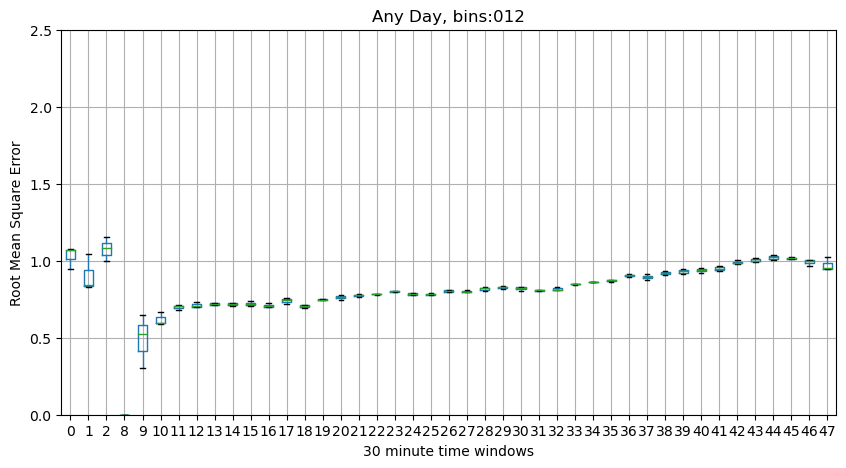

In [104]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

fig, ax = plt.subplots(figsize=(10, 5))
mse_df['time_window'] = mse_df.index
mse_df['time_window'].to_numpy()
mse_df['time_window'] = mse_df['time_window'].to_numpy().astype('int')
mse_df = mse_df.reset_index(drop=True).set_index('time_window')

mse_df.T.boxplot(ax=ax)

ax.set_title("Any Day, bins:012")
ax.set_ylabel("Root Mean Square Error")
ax.set_xlabel("30 minute time windows")
ax.set_ylim(0.0, 2.5)

fp = os.path.join('plots', 'any_day_simple_012.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

In [112]:
rf_df, ix_map, ohe_encoder, percentiles = triplevel_utils.prepare_df_for_training(tdf, cat_features, ord_features, target=TARGET)
rf_df, percentiles = triplevel_utils.adjust_bins(rf_df, TARGET=TARGET, percentiles=percentiles)
drop_cols = ['route_id', 'route_direction_name', 'block_abbr', 'y_reg100', 'y_reg095', 'transit_date', 'is_holiday', 'route_id_direction']
drop_cols = [col for col in drop_cols if col in rf_df.columns]
rf_df = rf_df.drop(drop_cols, axis=1)
rf_df = rf_df[rf_df['y_class'] >= 2]

y = rf_df.pop('y_class')
y = y - 2
X = rf_df

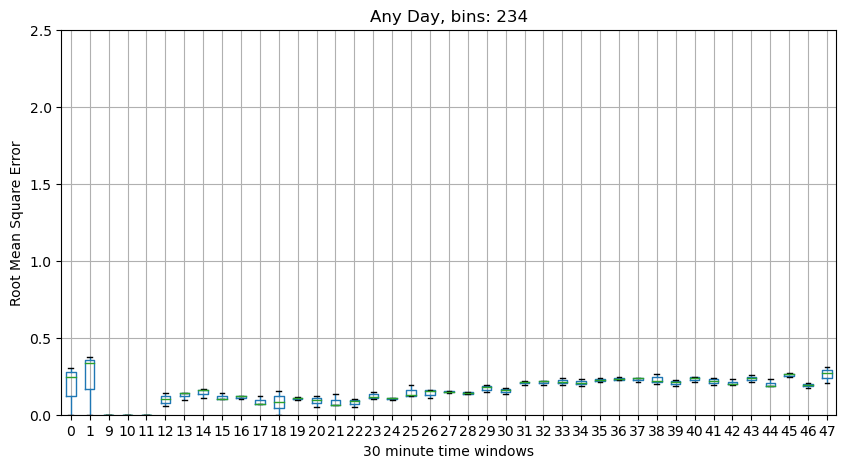

In [115]:
columns = rf_df.columns

# n_estimators  = search_results.best_params_['n_estimators']
# max_depth     = search_results.best_params_['max_depth']
# learning_rate = search_results.best_params_['learning_rate']
# gamma         = search_results.best_params_['gamma']
objective = 'multi:softmax'

skf = StratifiedKFold(n_splits=FOLDS, random_state=RANDOM_SEED, shuffle=True)
skf.get_n_splits(X, y)

results_df_arr = []
for train_index, test_index in skf.split(X, y):
    _X_train, _X_test = X.iloc[train_index], X.iloc[test_index]
    _y_train, _y_test = y.iloc[train_index], y.iloc[test_index]
    
    # model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth,
    #                           learning_rate=learning_rate, use_label_encoder=False, 
    #                           gamma=gamma, num_class=3,
    #                           objective=objective, eval_metric='mlogloss')
    model = xgb.XGBClassifier(use_label_encoder=False, objective=objective, eval_metric='mlogloss', num_class=3)
    model.fit(_X_train, _y_train, verbose=1)

    preds = model.predict(_X_test)
    _X_test = pd.DataFrame(_X_test, columns=columns)
    _X_test['y_pred'] = preds
    _X_test['y_true'] = _y_test
    res_df = _X_test[['time_window', 'y_true', 'y_pred']]
    results_df_arr.append(res_df)

mse_df = generate_results_over_time_window(results_df_arr)
fp = os.path.join('evaluation', 'any_day_234_results.pkl')
mse_df.to_pickle(fp)

fig, ax = plt.subplots(figsize=(10, 5))
mse_df['time_window'] = mse_df.index
mse_df['time_window'].to_numpy()
mse_df['time_window'] = mse_df['time_window'].to_numpy().astype('int')
mse_df = mse_df.reset_index(drop=True).set_index('time_window')

mse_df.T.boxplot(ax=ax)

ax.set_title("Any Day, bins: 234")
ax.set_ylabel("Root Mean Square Error")
ax.set_xlabel("30 minute time windows")
ax.set_ylim(0.0, 2.5)

fp = os.path.join('plots', 'any_day_simple_234.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

## Baseline

In [119]:
import numpy as np
import swifter

In [144]:
def get_statistical_prediction(row, percentile, lookback_duration, TARGET='y_reg100'):
    trip_id = row.trip_id
    transit_date = row.transit_date
    route_id_direction = row.route_id_direction
    lookback_date = transit_date - pd.Timedelta(lookback_duration)
    tdf = df[(df['transit_date'] >= lookback_date) & \
             (df['transit_date'] < transit_date)]
    tdf = tdf[(tdf['trip_id'] == trip_id) & \
              (tdf['route_id_direction'] == route_id_direction)]
    if tdf.empty:
        return -1
    return np.percentile(tdf[TARGET].to_numpy(), percentile)

In [145]:
processed_triplevel = os.path.join('data', 'processed', 'triplevel_df.parquet')
df = pd.read_parquet(processed_triplevel, engine='auto')
df = df.dropna()
# Removing time_window in case a different one will be used
df = df.drop(['time_window', 'load'], axis=1)
df = df.reset_index(drop=True)
df = df.sort_values(['block_abbr', 'transit_date', 'arrival_time', 'route_id_direction'])

FOLDS = 3
RANDOM_SEED = 100
WINDOW = 30
PAST_TRIPS = 5
TARGET = 'y_reg100'

percentiles = [(0.0, 9.0), (10.0, 16.0), (17.0, 100.0)]
df['y_class'] = df[TARGET].swifter.apply(lambda x: data_utils.get_class(x, percentiles))
df['y_class'] = df['y_class'].astype('int')

df['minute'] = df['arrival_time'].dt.minute
df['minuteByWindow'] = df['minute'] // WINDOW
df['temp'] = df['minuteByWindow'] + (df['hour'] * 60 / WINDOW)
df['time_window'] = np.floor(df['temp']).astype('int')
df = df.drop(columns=['minute', 'minuteByWindow', 'temp'], axis=1)
df.head()

Pandas Apply:   0%|          | 0/430404 [00:00<?, ?it/s]

,trip_id,transit_date,arrival_time,year,month,route_id,route_direction_name,block_abbr,dayofweek,hour,temperature,humidity,precipitation_intensity,scheduled_headway,actual_headways,y_reg100,y_reg095,route_id_direction,is_holiday,traffic_speed,y_class,time_window
392045,195842,2020-01-01,2020-01-01 10:27:12,2020,1,3,FROM DOWNTOWN,300,4,10,40.150002,0.616000,0.000000,4800.000000,4811.800000,8.0,8.0,3_FROM DOWNTOWN,True,18.639604,0,20
286072,195844,2020-01-01,2020-01-01 11:50:51,2020,1,3,FROM DOWNTOWN,300,4,11,45.149673,0.519065,0.000000,2400.000000,2636.369565,3.0,2.0,3_FROM DOWNTOWN,True,17.891478,0,23
392046,195850,2020-01-01,2020-01-01 15:48:28,2020,1,3,FROM DOWNTOWN,300,4,15,52.428334,0.364667,0.000000,2400.000000,2410.222222,7.0,7.0,3_FROM DOWNTOWN,True,17.727612,0,31
301301,195852,2020-01-01,2020-01-01 17:20:28,2020,1,3,FROM DOWNTOWN,300,4,17,49.563932,0.461733,0.000000,2400.000000,2124.422222,5.0,4.8,3_FROM DOWNTOWN,True,17.823639,0,34
256070,195743,2020-01-02,2020-01-02 07:03:44,2020,1,3,FROM DOWNTOWN,300,5,7,47.708799,0.632378,0.000224,4703.733333,4720.133333,14.0,13.8,3_FROM DOWNTOWN,False,18.014706,1,14


In [ ]:
skf = StratifiedKFold(n_splits=FOLDS, random_state=RANDOM_SEED, shuffle=True)
X, y = df[['transit_date', 'trip_id', 'arrival_time', 'route_id_direction', 'time_window', TARGET]], df['y_class']
skf.get_n_splits(X, y)

lookback_distances = ['4W', '2W', '1W']
percentile = 1.0
results_df_arr = []
for _, test_index in skf.split(X, y):
    for lookback_distance in lookback_distances:
        baseline_X = X.iloc[test_index]
        baseline_Y = y.iloc[test_index]
        
        baseline_X['y_pred'] = baseline_X.swifter.apply(lambda x: get_statistical_prediction(x, percentile, lookback_distance, TARGET=TARGET), axis=1)
        baseline_X['y_true'] = baseline_Y.to_numpy()
        res_df = baseline_X[['time_window', 'y_true', 'y_pred']]
        results_df_arr.append(res_df)
    break

In [152]:
results_df_arr[0]['y_pred_class'] = results_df_arr[0]['y_pred'].apply(lambda x: data_utils.get_class(x, percentiles))
results_df_arr[1]['y_pred_class'] = results_df_arr[1]['y_pred'].apply(lambda x: data_utils.get_class(x, percentiles))
results_df_arr[2]['y_pred_class'] = results_df_arr[2]['y_pred'].apply(lambda x: data_utils.get_class(x, percentiles))
df1 = results_df_arr[0].dropna()
df2 = results_df_arr[1].dropna()
df3 = results_df_arr[2].dropna()
df1 = df1[['time_window', 'y_true', 'y_pred_class']]
df2 = df2[['time_window', 'y_true', 'y_pred_class']]
df3 = df3[['time_window', 'y_true', 'y_pred_class']]
df1 = df1.rename(columns={'y_pred_class': 'y_pred'})
df2 = df2.rename(columns={'y_pred_class': 'y_pred'})
df3 = df3.rename(columns={'y_pred_class': 'y_pred'})
mse_df = generate_results_over_time_window([df1, df2, df3])
fp = os.path.join('evaluation', 'baseline_012_results.pkl')
mse_df.to_pickle(fp)

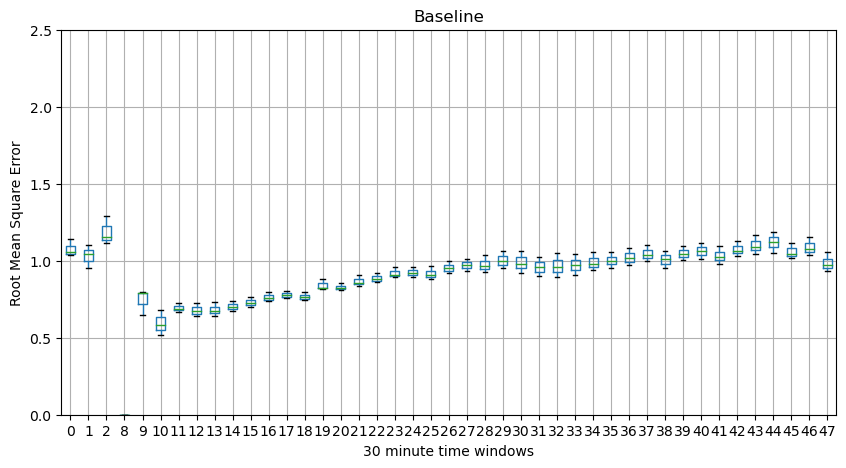

In [155]:
fig, ax = plt.subplots(figsize=(10, 5))
mse_df['time_window'] = mse_df.index
mse_df['time_window'].to_numpy()
mse_df['time_window'] = mse_df['time_window'].to_numpy().astype('int')
mse_df = mse_df.reset_index(drop=True).set_index('time_window')

mse_df.T.boxplot(ax=ax)

ax.set_title("Baseline")
ax.set_ylabel("Root Mean Square Error")
ax.set_xlabel("30 minute time windows")
ax.set_ylim(0.0, 2.5)

fp = os.path.join('plots', 'day_ahead_baseline_012.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

### Baseline 234

In [157]:
processed_triplevel = os.path.join('data', 'processed', 'triplevel_df.parquet')
df = pd.read_parquet(processed_triplevel, engine='auto')
df = df.dropna()
# Removing time_window in case a different one will be used
df = df.drop(['time_window', 'load'], axis=1)
df = df.reset_index(drop=True)
df = df.sort_values(['block_abbr', 'transit_date', 'arrival_time', 'route_id_direction'])

FOLDS = 3
RANDOM_SEED = 100
WINDOW = 30
PAST_TRIPS = 5
TARGET = 'y_reg100'
df = df[df[TARGET] >= 17]

percentiles = [(16.0, 55.0), (56.0, 75.0), (76.0, 100.0)]
df['y_class'] = df[TARGET].swifter.apply(lambda x: data_utils.get_class(x, percentiles))
df['y_class'] = df['y_class'].astype('int')

df['minute'] = df['arrival_time'].dt.minute
df['minuteByWindow'] = df['minute'] // WINDOW
df['temp'] = df['minuteByWindow'] + (df['hour'] * 60 / WINDOW)
df['time_window'] = np.floor(df['temp']).astype('int')
df = df.drop(columns=['minute', 'minuteByWindow', 'temp'], axis=1)
df.head()

Pandas Apply:   0%|          | 0/128118 [00:00<?, ?it/s]

,trip_id,transit_date,arrival_time,year,month,route_id,route_direction_name,block_abbr,dayofweek,hour,temperature,humidity,precipitation_intensity,scheduled_headway,actual_headways,y_reg100,y_reg095,route_id_direction,is_holiday,traffic_speed,y_class,time_window
301336,195743,2020-01-03,2020-01-03 07:03:16,2020,1,3,FROM DOWNTOWN,300,6,7,52.718066,0.959467,0.000000,4703.733333,4775.977778,18.0,18.00,3_FROM DOWNTOWN,False,17.331706,0,14
316472,195738,2020-01-03,2020-01-03 08:40:30,2020,1,3,FROM DOWNTOWN,300,6,8,53.563000,0.953000,0.000500,1300.717391,735.456522,18.0,17.75,3_FROM DOWNTOWN,False,17.761048,0,17
135589,195775,2020-01-03,2020-01-03 09:28:04,2020,1,3,TO DOWNTOWN,300,6,9,54.412660,0.957900,0.000010,5275.380000,5285.440000,21.0,18.00,3_TO DOWNTOWN,False,17.401242,0,18
286104,195732,2020-01-03,2020-01-03 11:30:46,2020,1,3,FROM DOWNTOWN,300,6,11,56.139999,0.960000,0.000200,5400.000000,5667.913043,24.0,23.00,3_FROM DOWNTOWN,False,16.189918,0,23
407034,195769,2020-01-03,2020-01-03 12:20:19,2020,1,3,TO DOWNTOWN,300,6,12,56.868139,0.956080,0.009118,5400.000000,5432.640000,20.0,20.00,3_TO DOWNTOWN,False,16.019135,0,24


In [158]:
skf = StratifiedKFold(n_splits=FOLDS, random_state=RANDOM_SEED, shuffle=True)
X, y = df[['transit_date', 'trip_id', 'arrival_time', 'route_id_direction', 'time_window', TARGET]], df['y_class']
skf.get_n_splits(X, y)

lookback_distances = ['4W', '2W', '1W']
percentile = 1.0
results_df_arr = []
for _, test_index in skf.split(X, y):
    for lookback_distance in lookback_distances:
        baseline_X = X.iloc[test_index]
        baseline_Y = y.iloc[test_index]
        
        baseline_X['y_pred'] = baseline_X.swifter.apply(lambda x: get_statistical_prediction(x, percentile, lookback_distance, TARGET=TARGET), axis=1)
        baseline_X['y_true'] = baseline_Y.to_numpy()
        res_df = baseline_X[['time_window', 'y_true', 'y_pred']]
        results_df_arr.append(res_df)
    break

Pandas Apply:   0%|          | 0/42706 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/42706 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/42706 [00:00<?, ?it/s]

In [159]:
results_df_arr[0]['y_pred_class'] = results_df_arr[0]['y_pred'].apply(lambda x: data_utils.get_class(x, percentiles))
results_df_arr[1]['y_pred_class'] = results_df_arr[1]['y_pred'].apply(lambda x: data_utils.get_class(x, percentiles))
results_df_arr[2]['y_pred_class'] = results_df_arr[2]['y_pred'].apply(lambda x: data_utils.get_class(x, percentiles))
df1 = results_df_arr[0].dropna()
df2 = results_df_arr[1].dropna()
df3 = results_df_arr[2].dropna()
df1 = df1[['time_window', 'y_true', 'y_pred_class']]
df2 = df2[['time_window', 'y_true', 'y_pred_class']]
df3 = df3[['time_window', 'y_true', 'y_pred_class']]
df1 = df1.rename(columns={'y_pred_class': 'y_pred'})
df2 = df2.rename(columns={'y_pred_class': 'y_pred'})
df3 = df3.rename(columns={'y_pred_class': 'y_pred'})
mse_df = generate_results_over_time_window([df1, df2, df3])
fp = os.path.join('evaluation', 'baseline_234_results.pkl')
mse_df.to_pickle(fp)

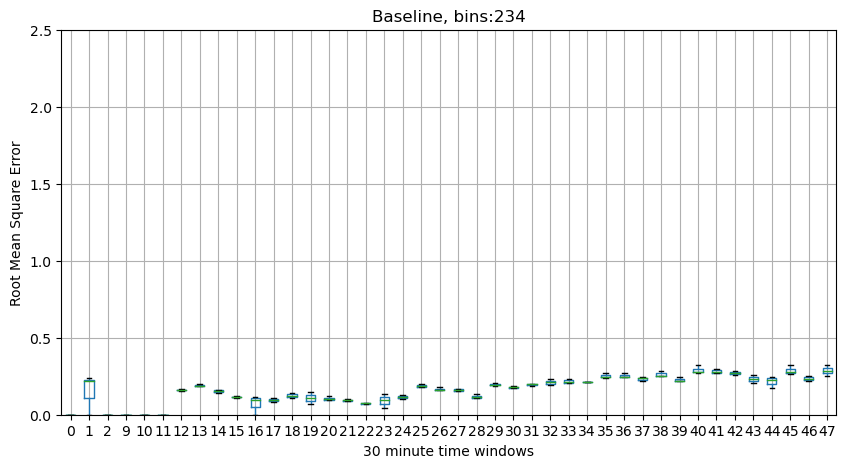

In [160]:
fig, ax = plt.subplots(figsize=(10, 5))
mse_df['time_window'] = mse_df.index
mse_df['time_window'].to_numpy()
mse_df['time_window'] = mse_df['time_window'].to_numpy().astype('int')
mse_df = mse_df.reset_index(drop=True).set_index('time_window')

mse_df.T.boxplot(ax=ax)

ax.set_title("Baseline, bins:234")
ax.set_ylabel("Root Mean Square Error")
ax.set_xlabel("30 minute time windows")
ax.set_ylim(0.0, 2.5)

fp = os.path.join('plots', 'day_ahead_baseline_234.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')